# A simple and flexible model for record matching

#### Libraries needed

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import make_union, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier as Classifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans as Cluster
plt.style.use('fivethirtyeight')

from suricate.lrdftransformers import VectorizerConnector, ExactConnector, FuzzyConnector, VisualHelper
from suricate.preutils import createmultiindex
from suricate.preutils.scores import scores
from suricate.lrdftransformers.cluster import ClusterQuestions, ClusterClassifier
from suricate.pipeline import PipeSbsClf, PruningLrSbsClf, PipeLrClf
from suricate.sbsdftransformers import FuncSbsComparator

#### Load the data

In [2]:
n_lines = 100
filepath_left = '/Users/paulogier/81-GithubPackages/suricate/suricate/data/left.csv'
filepath_right = '/Users/paulogier/81-GithubPackages/suricate/suricate/data/right.csv'
filepath_training = '/Users/paulogier/81-GithubPackages/suricate/suricate/data/trainingdata.csv'
left = pd.read_csv(filepath_left, index_col=0, nrows=n_lines, dtype=str)
right = pd.read_csv(filepath_right, index_col=0, nrows=n_lines, dtype=str)
y_true = pd.read_csv(filepath_training, usecols=['ix_left', 'ix_right', 'y_true']).set_index(['ix_left', 'ix_right'])['y_true']
df_X = [left, right]
y_true = y_true.loc[
    y_true.index.intersection(createmultiindex(X=df_X))
]
n_possible_pairs= left.shape[0]*right.shape[0]
print('Two datasets of size {} and {}  rows yield:\n {} possible pairs to scan --> manually exhausting'.format(left.shape[0], right.shape[0], n_possible_pairs))
left.sample(5)

Two datasets of size 500 and 500  rows yield:
 250000 possible pairs to scan --> manually exhausting


,name,street,city,postalcode,duns,countrycode
ix,,,,,,
3c4377c9-7da5-45b2-b9ab-4181554594ee,ergonomia verlag ohg,29a julius halder s trasse,stuttgart,70597,NaN,DE
0a6ce927-3fc5-4a4c-8a62-7fcbd0b5b9c7,abstract electronics inc,11526 53rd st n,clearwater,33760-4825,NaN,US
30e90e70-6f80-4a70-ba69-ff2c6a1d61d9,ametek mro florida inc,5900 nw 97th ave,doral,33178-1642,NaN,US
42b4a934-8b7a-489d-b905-150dc9595246,rdmadrid sl,79 1 calle de caleruega,madrid,28033,NaN,ES
7a037111-f074-4934-bec9-3042d2a26421,dr ursula matschke,33 emilienstr,stuttgart,70563,NaN,DE


# How similar are the records with one another?

#### The framework is fully compatible with open-source Scikit-Learn Machine Learning libraries

In [3]:
scorer = make_union(*[
    VectorizerConnector(on='name', analyzer='word', ngram_range=(1,2)),
     VectorizerConnector(on='name', analyzer='char', ngram_range=(1,2)),
    VectorizerConnector(on='street', analyzer='word', ngram_range=(1,2)),
    VectorizerConnector(on='city', analyzer='char', ngram_range=(1,2)),
    ExactConnector(on='duns'),
    ExactConnector(on='countrycode')
])
imp = SimpleImputer(strategy='constant', fill_value=0)

pca = PCA(n_components=2)
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
t2d = make_pipeline(*[scorer, imp, pca, scaler])

X_score2d = t2d.fit_transform(df_X)

#### Time needed to process the data

In [4]:
# %%timeit
# t2.fit_transform(df_X)

In [5]:
#print('{} pairs processed per second'.format(df_X[0].shape[0]*df_X[1].shape[0] / 8))

### Density plot: how similar are the matches on a 2-d space
Using a sample of maximum 500 lines out of all possible pairs as it is computation intensive

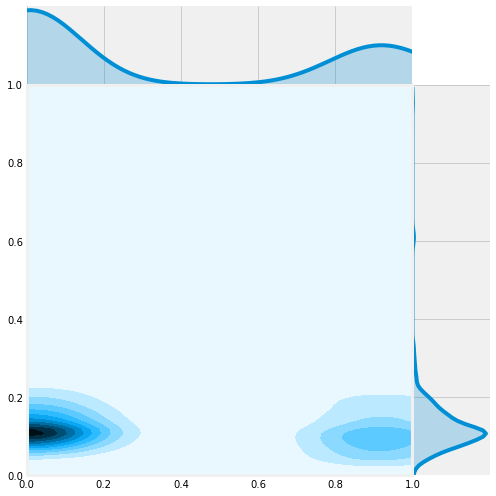

In [6]:
n_samples= np.random.choice(n_possible_pairs, min(500, n_possible_pairs))
X_sample2d = X_score2d[n_samples]
ax = sns.jointplot(X_sample2d[:,0], X_sample2d[:,1], kind="kde", height=7, space=0, xlim=(0,1.0), ylim=(0,1.0))

# Asking hard questions to train the model

### Cluster your data
Support all sklearn clusters

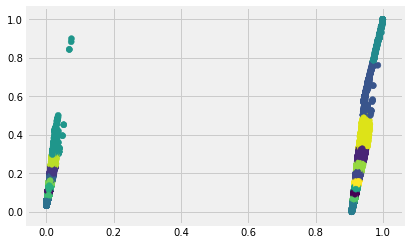

In [7]:
cluster = Cluster(n_clusters=20)
explorer = ClusterQuestions(transformer=t2d, cluster=cluster)
y_cluster = explorer.fit_predict(X=df_X)
plt.scatter(X_score2d[:, 0], X_score2d[:, 1], c=y_cluster);

### Ask representative questions

In [8]:
questions1 = explorer.representative_questions(n_questions=40)
questions1.sort_values(by='similarity').sample(5)

,,name_left,name_right,street_left,street_right,city_left,city_right,postalcode_left,postalcode_right,duns_left,duns_right,countrycode_left,countrycode_right,cluster,similarity
ix_left,ix_right,,,,,,,,,,,,,,
f7da5ee1-7c3f-4d8d-b644-d01791d1793d,b2fb7aed-3fe5-485e-a4a2-b42e8508f893,e a elektro automatik gmbh,hohmann elektronik gmbh,31 37 helmholtzstr,36 eisenbahnstr,viersen,germering,41747,82110,344304634.0,NaN,DE,DE,2,0.936113
536d4a08-8f02-4ec5-9b7d-e02fa09beb6a,8a36d910-8da0-41b5-ae99-1a9112e04d51,ge aviation,kitotec gmbh,arle court,11 carl zeiss str,cheltenham,meckenheim,gl51 0tp,53340,505518316.0,NaN,GB,DE,17,0.016725
39c6607f-e357-4d3f-82af-268b59a2b55e,243d63e0-caeb-484c-ad42-86950580b47a,hoefer gmbh,bmv biberacher metallveredelung,14a keferloher str,3 walkstr,haar,biberach,85540,88400,NaN,321963993.0,DE,DE,0,0.918134
591099fe-6fcd-4a72-9e4b-9365594dbb41,4d76ab1a-6b13-44b7-ab41-2ad1be2a1aea,nespresso deutschland gmbh,leg industrie elektronik gmbh,speditionsstrae,2 textilstr,dusseldorf,viersen,40221,41751,NaN,NaN,DE,DE,19,0.922606
35b7cba1-e1db-482a-9f42-f01691e97e8f,65835406-e391-4c00-9079-0ba370f29897,clinter traducciones e,iberia,57 calle gran via,barajas zona industrial,madrid,madrid,28013,28042,NaN,NaN,ES,ES,5,0.947012


In [9]:
answer1 = y_true
cluster_composition = explorer.cluster_composition(y=answer1, normalize='index')
cluster_composition

y_true,0,1
cluster,,
0,1.000000,0.000000
2,1.000000,0.000000
4,1.000000,0.000000
5,0.865248,0.134752
8,1.000000,0.000000
9,0.121076,0.878924
10,1.000000,0.000000
11,1.000000,0.000000
14,1.000000,0.000000


### Asking more pointed questions on mixed clusters

In [11]:
questions2 = explorer.pointed_questions(y=answer1,n_questions=10)
questions2.sort_values(by='similarity')

,,name_left,name_right,street_left,street_right,city_left,city_right,postalcode_left,postalcode_right,duns_left,duns_right,countrycode_left,countrycode_right,cluster,similarity
ix_left,ix_right,,,,,,,,,,,,,,
834f832d-7739-422e-b98e-b8fc3b709960,0be2de31-df48-42bb-8f04-c87e2a8b7b16,flm gmbhfoto licht und messtechn zubeh r,architektenkammer der,18 schtzen strae,geeren,emmendingen,bremen,79312,28195,312664618.0,326694234.0,DE,DE,18,0.932193
6694cef8-c256-4ead-bb58-b9e9a7bd15f1,642af620-e0d7-4927-9bbf-41968e451556,roth gmbh und co kg,mewa textil service ag co,28 zusamstr,hermann gebauer str,augsburg,lauenburg,86165,21481,313234338.0,317747988.0,DE,DE,18,0.932840
8183683d-b323-4739-ae25-bc8297b35cee,097bb9e6-13f7-4409-b0c6-9ef90ffc9839,hotel und gasthof bauer,waycon positionsmesstechnik gmbh,mnchner str,4 mehlbeerenstr,feldkirchen,taufkirchen,85622,82024,322170721.0,315952668.0,DE,DE,18,0.933214
19c06e93-9aaf-4165-80ef-50f4e63ae433,960e78f7-baa3-4215-a857-5937f948daa3,denzel kg,jura zentralservice singen,12 mhlwinkel,16 otto hahn str,wertingen,singen,86637,78224,316456565.0,NaN,DE,DE,18,0.934300
efc19188-95f7-401f-8fcc-4fc6d69e2c1b,31977c06-ae68-4fa8-a5ad-470ffafca635,tts tooltechnic systems ag co kg tts tooltechn...,siemens ag,20 wertstr,16 hartmannstr,wendlingen,erlangen,73240,91052,NaN,NaN,DE,DE,18,0.934909
6694cef8-c256-4ead-bb58-b9e9a7bd15f1,2cf23ea5-31ad-45e5-9306-8181eddf6fdd,roth gmbh und co kg,biko bildungskooperation regionen,28 zusamstr,schillerstrasse,augsburg,ludwigsburg,86165,71638,313234338.0,340562058.0,DE,DE,18,0.934992
a05b9a23-b7ed-4f4c-a7d9-f6c846e8d85b,ed6e3cae-c50c-406c-9413-a9e11cd7adf4,maschinenhandel meyer,aspen produkte handels gmbh,10b reinhard rube str,160 beihinger str,gottingen,benningen,37077,71726,341887429.0,NaN,DE,DE,18,0.935394
218daa95-d7f0-457e-a789-652ebeac0c28,1844bd09-24b5-4560-bc8c-2aa2b186c6a7,busse design engineering gmbh,hotel landgasthof euringer ltd,18 nersinger str,manchingerstrae,elchingen,manching,89275,85077,NaN,NaN,DE,DE,18,0.935666
01c34b3a-67aa-418e-95e2-43b6eb926fd3,8060723b-a4b4-4dfd-848f-b5c5b2336828,haufe gmbhcokg,weila transport gmbh cokg,weilburger str,11 gewerbering,usingen,tussling,61250,84577,NaN,34493966.0,DE,DE,18,0.936194


In [13]:
answer2 = y_true
cluster_composition = explorer.cluster_composition(y=y_true, normalize='index').sort_values(by=1, ascending=False)
cluster_composition

y_true,0,1
cluster,,
9,0.121076,0.878924
5,0.865248,0.134752
18,0.982456,0.017544
0,1.000000,0.000000
2,1.000000,0.000000
4,1.000000,0.000000
8,1.000000,0.000000
10,1.000000,0.000000
11,1.000000,0.000000


### Scatter plot using labelled data

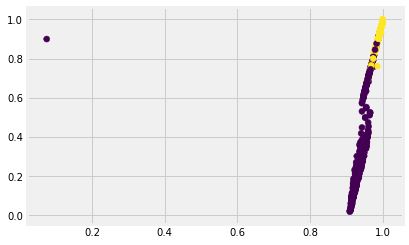

In [14]:
Xpd = pd.DataFrame(data=X_score2d, index=createmultiindex(df_X))
on_ix = y_true.index.intersection(Xpd.index)
plt.scatter(Xpd.loc[on_ix, 0], Xpd.loc[on_ix, 1], c=y_true.loc[on_ix]);

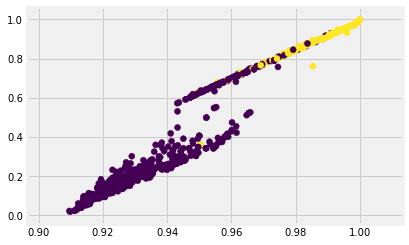

In [15]:
# we remove the outlier to zoom on the separation frontier
on_ix2 = on_ix.drop(Xpd.loc[on_ix, 0].idxmin())
plt.scatter(Xpd.loc[on_ix2, 0], Xpd.loc[on_ix2, 1], c=y_true.loc[on_ix2]);

# Make prediction using training data

### We use the cluster classifier to deal the data in 3 parts:
With the similarity matrix from the (left, right) comparators such defined, the clustering done, and the training data, we can thus categorize the clusters in three groups
- the clusters where there is no positive matches in the training data and where all the pairs are surely not a match (the vast majority of them)
- the clusters where there is only positive matches and where we are pretty confident that these are real matches
- the clusters where there is a mixed of positive and negative samples and where we need further comparators and more intelligent classifiers to take a decision

The ClusterClassifier, using the similarity matrix and the training data, gives the following predictions:
- 0 for sure non matches
- 1 for uncertain matches
- 2 for sure matches

### Repartition of the clusters in terms of proportion

In [16]:
clf1 = ClusterClassifier(cluster=cluster)
clf1.fit(X=Xpd.loc[on_ix], y=y_true)
y_pred_lr = pd.Series(clf1.predict(X=X_score2d), index= createmultiindex(df_X))
y_pred_lr.value_counts()/y_pred_lr.shape[0]

0    0.91344
1    0.08656
dtype: float64

### We can pipeline the transformer Left Right and the classifier using a class called PipeLrClf

In [17]:
lrmodel = PipeLrClf(transformer=t2d, classifier=clf1)
# lr model has fit and predict capabilities

### Pruning the data
Concentrating on the 2% of mixed matches for further analysis and classifying 98% of the possible pairs is called pruning. It helps a lot reduce the number of comparisons done (in-depth comparison are much more memory-intense)

### Doing further analysis
We bring in new comparators, with compare the dataframe on a side-by-side basis. They use in particular the famous FuzzyWuzzy Library using the Levenshtein distance. Moreover, we can bring any classifier we want from scikit-learn supervised machine learning libraries. We Pipe SbsComparators and Classifier using a clas called PipeSbsClf

In [18]:
transformer2 = make_union(*[
    FuncSbsComparator(on='name', comparator='fuzzy'),
    FuncSbsComparator(on='name', comparator='token'),
    FuncSbsComparator(on='street', comparator='fuzzy'),
    FuncSbsComparator(on='city', comparator='fuzzy'),
    FuncSbsComparator(on='postalcode', comparator='fuzzy'),

])
imp2 = SimpleImputer(strategy='constant', fill_value=0)
pca3 = PCA(n_components=3)
transformer2 = make_pipeline(*[transformer2, imp2, pca3])
clf2 = Classifier()
sbsmodel = PipeSbsClf(transformer=transformer2, classifier=clf2)

### Pipelining the two steps above
This is done using a class Called aptly PruningLrSbsClf

In [21]:
pipe = PruningLrSbsClf(lrmodel=lrmodel, sbsmodel=sbsmodel)
pipe.fit(X=df_X, y_lr=y_true, y_sbs=y_true)
y_pred = pd.Series(
    data=pipe.predict(X=df_X),
    index=createmultiindex(X=df_X),
    name='y_pred'
)
y_pruning = pd.Series(data=np.where(y_pred_lr >1, 1, y_pred_lr), index= createmultiindex(X=df_X))
pruningscores = scores(y_true=y_true, y_pred=y_pruning)
finalscores = scores(y_true=y_true, y_pred=y_pred)
for c in pruningscores.keys():
    print('\n {}\n pruning:{}\nfinal{}\n'.format(c, pruningscores[c], finalscores[c]))


 precision
 pruning:0.42857142857142855
final1.0


 recall
 pruning:1.0
final0.9953703703703703


 f1
 pruning:0.6
final0.9976798143851509


 accuracy
 pruning:0.6363636363636364
final0.9987373737373737


 balanced_accuracy
 pruning:0.75
final0.9976851851851851



# Visualizing the possible matches
This is done via a class called VisualHelper. Useful to export to excel

In [22]:
viz = VisualHelper()
goodmatches= y_pred.loc[y_pred==1].index
sbs = viz.transform(X=df_X, on_ix=goodmatches, usecols=['name', 'street', 'city', 'postalcode', 'countrycode'])
sbs['confidence'] = y_pred_lr.loc[goodmatches]
sbs.reset_index(drop=False, inplace=True)

#### matches with very high confidence

In [25]:
sbs.loc[(sbs['confidence']==2) & (sbs['ix_left']!=sbs['ix_right'])].sample(5)

ValueError: 'a' must be greater than 0 unless no samples are taken

#### probable matches

In [29]:
sbs.loc[(sbs['confidence']==1)].sample(5)

,ix_left,ix_right,name_left,name_right,street_left,street_right,city_left,city_right,postalcode_left,postalcode_right,countrycode_left,countrycode_right,confidence
301,02f8a26c-b153-4064-bd87-9436108500d4,5f51f868-8079-46c6-98f4-7f6b6ff7bf14,manfrotto distribution,manfrotto distribution,44 rue de la couture,44 rue de la couture,rungis,rungis,94390,94390,FR,FR,1
70,f0d34671-a63e-4a7a-a0fd-91de34614366,08798f70-87df-48a5-9dee-6f0460e60429,hamilton sundstrand,hamilton sundstrand,cl4747 harrison ave,7002 po box,rockford,rockford,61125,61124,US,US,1
9,303a4b5d-b64c-4ec3-8026-61ddc082efa0,69e3533d-b706-4b98-8979-bceef511318c,muehlinghaus hildesheim,muehlinghaus hildesheim,klingelholl,klingelholl,wuppertal,wuppertal,42281,42281,DE,DE,1
65,3c4c091c-b787-4017-a393-b14cd4e68dc6,a95f5f08-9462-4da8-b941-f8c7148fd5ce,industrie und,industrie und handelskammer ulm,olgastr,olgastr,ulm,ulm,89073,89073,DE,DE,1
267,c1cdd98b-9bd8-449e-9251-5322b07e562a,cb645085-d469-44e7-b2b8-89fbd2a0cb21,goodrich sensorsintegrated syst,goodrich corporation,14300 judicial rd,14300 judicial rd,burnsville,burnsville,55306-4890,55306-4890,US,US,1
